# **Final Project ML for Time Series**

### **Subject**: *A Symbolic Representation of Time Series, with Implications for Streaming Algorithms*, Jessica Lin, Eamonn Keogh, Stefano Lonardi, Bill Chiu

#### **Authors**: Tom Rossa and Naïl Khelifa

## **Table des Matières**
1. [Introduction](#introduction)
2. [Importation des Bibliothèques et des Données](#importation-des-bibliothèques-et-des-données)
3. [Exploration des Données](#exploration-des-données)
   - [Aperçu des Données](#aperçu-des-données)
   - [Statistiques Descriptives](#statistiques-descriptives)
   - [Visualisation des Données](#visualisation-des-données)
4. [Prétraitement des Données](#prétraitement-des-données)
   - [Gestion des Valeurs Manquantes](#gestion-des-valeurs-manquantes)
   - [Normalisation et Transformation](#normalisation-et-transformation)
   - [Encodage des Variables Catégoriques](#encodage-des-variables-catégoriques)
5. [Sensibilité des données aux hyper-paramètres](#optimisation-et-tuning-des-hyperparamètres)
6. [Clustering](#clustering)
   - [Hierarchical Clustering](#hierarchical)
   - [Partitional Clustering](#partitional)
   - [Sensibilité aux paramètres](#other)
   - [Conclusion classification](#conclusion-clustering)
7. [Classification](#classification)
   - [Nearest Neighbor Classification](#neighbor)
   - [Sensibilité aux paramètres](#other)
   - [Conclusion classification](#conclusion-classification)
8. [Query by content (indexing)](#indexing)
9. [Other](#other-data-mining)
   - [Anomaly Detection](#anomaly)
   - [Motif discovery](#motif)
   - [Other](#other)
   - [Conclusion clustering](#conclusion-other-data-mining)
10. [Résultats et Interprétation](#résultats-et-interprétation)
11. [Conclusion et Perspectives](#conclusion-et-perspectives)


## **Introduction**

L'objet de ce travail est de reproduire et d'étendre les expériences réalisées dans le papier *A Symbolic Representation of Time Series, with Implications for Streaming Algorithms* (Lin et al.). 

----------------------------------------------------------------------------------------------------------------------------------------------
### Différentes approches pour la symbolisation 
Dans ce travail, notre point de départ a été l'article *A Symbolic Representation of Time Series, with Implications for Streaming Algorithms* (Lin et al.). L'ancienneté de la méthode proposée, ainsi que la diversité des variantes de la méthode Symbolic Aggregate approXimation (SAX) introduite dans ce papier, nous a conduit à vouloir confronter toutes ces différentes méthodes entre elles et observer les points forts et faibles de celles-ci selon le type de données (classification en peu de classes ou beaucoup de classes, symbolisations de séries plus ou moins longues, clustering, etc.). Ainsi, à l'occasion de ce projet, nous allons comparer différentes méthodes de symbolisation de séries temporelles. 

Il existe beaucoup de littérature autour de ce procédé et de nombreuses méthodes, toutes plus inventives les unes des autres, ont émergé à ce sujet. La symbolisation consiste en la transformation d'une série temporelles de taille $N$, dont les valeurs évoluent dans un espace continu (souvent $\mathbb{R}$ pour des séries univariées), en un "mot" de taille $k << N$ formé à partir d'un alphabet de symboles fini de taille $A$. L'objectif de ce procédé étant de réduire massivement l'espace de stockage qu'occupe une série temporelle symbolisée, tout en perdant le moins possible d'information au sujet de cette série. Il existe plusieurs approches pour la symbolisation, chacune ayant des avantages et des inconvénients, que nous allons comparer pour les tâches de classification, clustering et indexation. Pour que la comparaison soit équitable, on observera à quel point est ce que les méthodes sont performantes pour ses tâches pour un alphabet donné, et une taille de mot donnée. 

Les méthodes que nous étudions sont les suivantes : 
- SAX (Symbolic Aggregate approXimation)
- ESAX (Extended SAX)
- TSAX (Trend SAX)
- 1D-SAX (One-Dimensional SAX)
- ASTRIDE (Adaptive Symbolic Time-series Representation for Indexing and DEnsity estimation)
- SFA (Symbolic Fourier Approximation) 
- BOSS (Bag of SFA Symbols) 

Les méthodes SAX, ESAX, TSAX, et 1D-SAX s'appuient sur la représentation PAA (Piecewise Aggregate Approximation). Cette technique divise la série temporelle en segments de taille égale, sur lesquels la série est approximée par une valeur constante correspondant à la moyenne des valeurs du segment. Une fois la PAA obtenue, on suppose que les valeurs de la série sont distribuées selon une loi normale centrée réduite. Cela permet de diviser l'espace des valeurs en plusieurs intervalles (ou bins), définis de manière à ce que chaque bin représente une aire égale sous la courbe de densité gaussienne. Pour SAX, chaque bin est associé à une lettre de l'alphabet, et la série est ensuite encodée en attribuant à chaque segment la lettre correspondant au bin où se situe sa moyenne. 

Les 3 autres méthodes capturent davantage d'information mais parfois au détriment de la compression de l'information. Sur chacun des segments, ESAX encode la valeur du minimum et maximum atteint par la série, ce traduisant par un mot 3 fois plus long que SAX pour un même nombre de segments et taille d'alphabet. TSAX ... Tandis que 1D-SAX encode la moyenne et la pente de la série sur chacun des segments dans leur alphabet respectif avant d'unir chaque association de symboles par un unique. Ainsi, la taille de l'alphabet peut vite croître rendant moins intéressante la méthode en terme de compression mais plus précise en terme d'approximation. 

Les méthodes SFA et BOSS reposent sur la symbolisation de la série dans l'espace des fréquences. En effet, elles analysent les caractéristiques des données temporelles à l'aide de la transformée de Fourier discrète (DFT), afin de capturer des informations pertinentes sur les motifs et les distributions des fréquences présentes dans la série temporelle. Cela permet une meilleure représentation des données tout en réduisant leur complexité, tout en maintenant une bonne fidélité dans la capture des informations essentielles pour les tâches de classification, de détection de tendances ou de détection de motifs. Les composantes spectrales portant le plus d'information sont sélectionnées à l'échelle de la database et un alphabet spécifique leur est associé. 

Enfin, l'innovation apportée par ASTRIDE est double puisqu'elle survient au moment de la segmentation de la série et de la création de l'alphabet. En effet, la segmentation de la série est adaptative et se fait par détection de change-points (souvent sur un critère de moyenne) à l'échelle de la database entière. C'est-à-dire que la segmentation qui fait le plus de sens pour l'ensemble des séries est conservée. Ainsi, elle repose sur le même principe que SAX mais les bins associées aux différentes lettres sont créées à partir des quantiles empiriques des moyennes sur chaque segment, de l'ensemble des séries de la database. Ce qui tient donc davantage compte des données que la méthode SAX pour une compression égale de l'information. 

Voici un résumé succint des principales caractéristiques et fonctionnement de ces méthodes : 

| **Caractéristique**              | **SAX**                              | **ESAX**                             | **TSAX**                              | **1D-SAX**                          | **ASTRIDE**                        | **SFA**                             | **BOSS**                            |
|-----------------------------------|---------------------------------------|---------------------------------------|----------------------------------------|--------------------------------------|-------------------------------------|--------------------------------------|--------------------------------------|
| **Segmentation**                 | Uniforme                             | Uniforme                             | Uniforme                              | Uniforme              | Adaptative                      | Uniforme                             | Fenêtre glissante                   |
| **Représentation**               | Symboles via moyennes                | Symboles via moyennes + min et max         | Symboles basés sur tendances          | Symboles combinant moyenne et pente  | Symbole de la mean| Symboles via spectre fréquentiel    | Histogramme des mots SFA sur la fenêtre glissante        |
| **Compression des données**      | Élevée                               | Moyenne                               | Moyenne                               | Faible                              | Élevée                             | Moyenne                             | Moyenne                             |
| **Résistance aux variations**    | Faible                               | Moyenne                               | Haute                                 | Moyenne                             | Haute                              | Moyenne                             | Moyenne                             |
| **Fidélité de reconstruction**   | Faible                               | Moyenne                               | Faible                                | Haute                               | Faible                             | Moyenne                             | Faible                              |
| **Avantages spécifiques**        | Simplicité et rapidité               | Capture des tendances locales         | Focus sur la direction globale         | Capture plus détaillée de la forme  | Capture des motifs structurés      | Analyse des fréquences (robustesse) | Analyse statistique des mots        |
| **Limitations**                  | Ignore les tendances et variations   | Complexité accrue                     | Ignore les valeurs exactes            | Complexité plus élevée              | Dépend fortement des motifs         | Nécessite la FFT                    | Taille des histogrammes élevée      |

Pour une série typique du dataset, nous allons procéder à sa symbolisation par les différentes méthodes. 

## **Importation des Bibliothèques et des Données**

### Bibliothèques

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
import scipy.stats as stats # for the breakpoints in SAX
from scipy.stats import norm
from dtw import dtw
import os

##Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

## TSLEARN
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset

## Custom : code implémenté par nous-même
from Symbol import SYMBOLS
from SFA import *
from ASTRIDE import *
from SAX_transf import *
from distances import MINDIST, TRENDIST
import utils
import warnings 

warnings.filterwarnings('ignore')


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Dans ce travail, on considérera trois bases de données contenant chacune une structure spécifique que l'on essaiera d'exploiter pour illustrer les différences entre chaque méthode. On donne une brève descriptions de celles-ci: 

### *1. ECG200 Dataset*

**Data Source:** [Link](https://timeseriesclassification.com/description.php?Dataset=ECG200)

**Donated By:** R. Olszewski  

**Description:**  
This dataset was formatted by R. Olszewski as part of his thesis *"Generalized feature extraction for structural pattern recognition in time-series data"* at Carnegie Mellon University, 2001. Each series traces the electrical activity recorded during one heartbeat. The two classes are:
- **Normal heartbeat**  
- **Myocardial Infarction**  


Ce qui est intéressant avec ce dataset est que la différence d'une classe à l'autre se voit dans les pics. 

#### Dataset Summary

| **Train Size** | **Test Size** | **Length** | **Number of Classes** | **Number of Dimensions** | **Type** |
|-----------------|--------------|------------|------------------------|--------------------------|----------|
| 100             | 100          | 96         | 2                      | 1                        | ECG      |


### *2. Computers Dataset*

**Data Source:** [Link](https://timeseriesclassification.com/description.php?Dataset=Computers)  
**Donated By:** J. Lines, A. Bagnall  

**Description:**  
These problems were taken from data recorded as part of a government-sponsored study called *Powering the Nation*. The intention was to collect behavioral data about how consumers use electricity within the home to help reduce the UK's carbon footprint.  

The data contains readings from 251 households, sampled in two-minute intervals over a month. Each series is of length 720 (representing 24 hours of readings taken every 2 minutes).  

**Classes:** Desktop and Laptop

#### Dataset Summary

| **Train Size** | **Test Size** | **Length** | **Number of Classes** | **Number of Dimensions** | **Type** |
|-----------------|--------------|------------|------------------------|--------------------------|----------|
| 250             | 250          | 720         | 2                      | 1                        | DEVICE      |

### *3. Adiac Dataset*


**Data Source:** [Link](https://timeseriesclassification.com/description.php?Dataset=Adiac)  
**Donated By:** A. Jalba  

**Description:**  
The *Automatic Diatom Identification and Classification (ADIAC)* project was a pilot study concerning automatic identification of diatoms (unicellular algae) based on images.  

The data was donated by Andrei Jalba, a PhD student on the project, which finished in the early 2000s. The outlines are extracted from thresholded images. Presumably, the time series are generated as the distance to a reference point (with the center being the obvious candidate).  

The data is very sinusoidal.

#### Dataset Summary

| **Train Size** | **Test Size** | **Length** | **Number of Classes** | **Number of Dimensions** | **Type**  |
|------------|-----------|--------|--------------------|-----------------------|-------|
| 390        | 391       | 176    | 37                 | 1                     | IMAGE |



L'idée est d'exploiter les spécificités de chaque dataset: 

1. ECG200: séries temporelles assez courtes et peu de classes.
2. Computers: séries temporelles plus longues et peu de classes.
3. Adiac: séries temporelles assez courtes et beaucoup de classes.

Pour justifier plus en détail le choix de ces bases de données, il convient de les visualiser. 

In [2]:
ECG200_X_train, ECG200_x_train, ECG200_y_train, ECG200_X_test, ECG200_x_test, ECG200_y_test = utils.generate_data(type="ECG200")
computers_X_train, computers_x_train, computers_y_train, computers_X_test, computers_x_test, computers_y_test = utils.generate_data(type="computers")
adiac_X_train, adiac_x_train, adic_y_train, adiac_X_test, adiac_x_test, adiac_y_test = utils.generate_data(type="adiac")

## **Exploration des données**

Dans cette section:

1. on commence par brièvement décrire les séries temporelles (leurs caractéristiques) dans chacune des bases de données,

2. on visualise la tendance moyenne de chaque série et sa distribution sur chaque classe (sauf sur le dataset *Adiac* car il contient 37 classes). Cette étape est importante car nous observerons que souvent, la différence entre une série d'une classe et la série d'une autre classe tiens à un petit motif que certaines méthodes de symbolisation parviennent t'as mieux saisir que d'autres.

### 1. *ECG200*

In [3]:
utils.describe_ecg_dataset(ECG200_x_train, ECG200_y_train, ECG200_x_test, ECG200_y_test)

Nombre d'exemples dans l'ensemble d'entraînement : 100
Nombre d'exemples dans l'ensemble de test : 100
Longueur des séries temporelles : 96


Répartition des classes (Ensemble d'entraînement) :
label
-1    31
 1    69
Name: count, dtype: int64

Répartition des classes (Ensemble de test) :
label
-1    36
 1    64
Name: count, dtype: int64




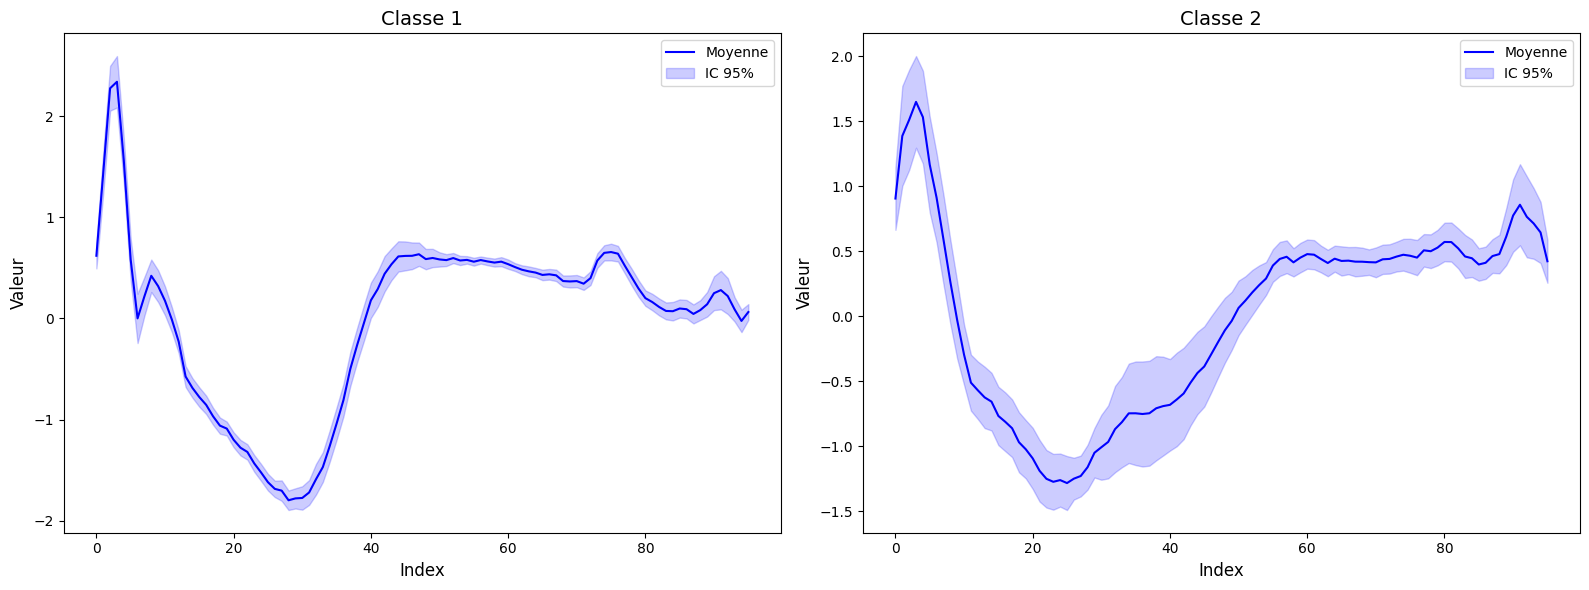

In [4]:
df0 = ECG200_X_train[ECG200_X_train["label"]==-1].iloc[:, :-1]
df1 = ECG200_X_train[ECG200_X_train["label"]==1].iloc[:, :-1]
utils.plot_classes(df0, df1, num_seg=None)

### *2. Computers*

In [5]:
utils.describe_ecg_dataset(computers_x_train, computers_y_train, computers_x_test, computers_y_test)

Nombre d'exemples dans l'ensemble d'entraînement : 250
Nombre d'exemples dans l'ensemble de test : 250
Longueur des séries temporelles : 720


Répartition des classes (Ensemble d'entraînement) :
label
1    125
2    125
Name: count, dtype: int64

Répartition des classes (Ensemble de test) :
label
1    125
2    125
Name: count, dtype: int64




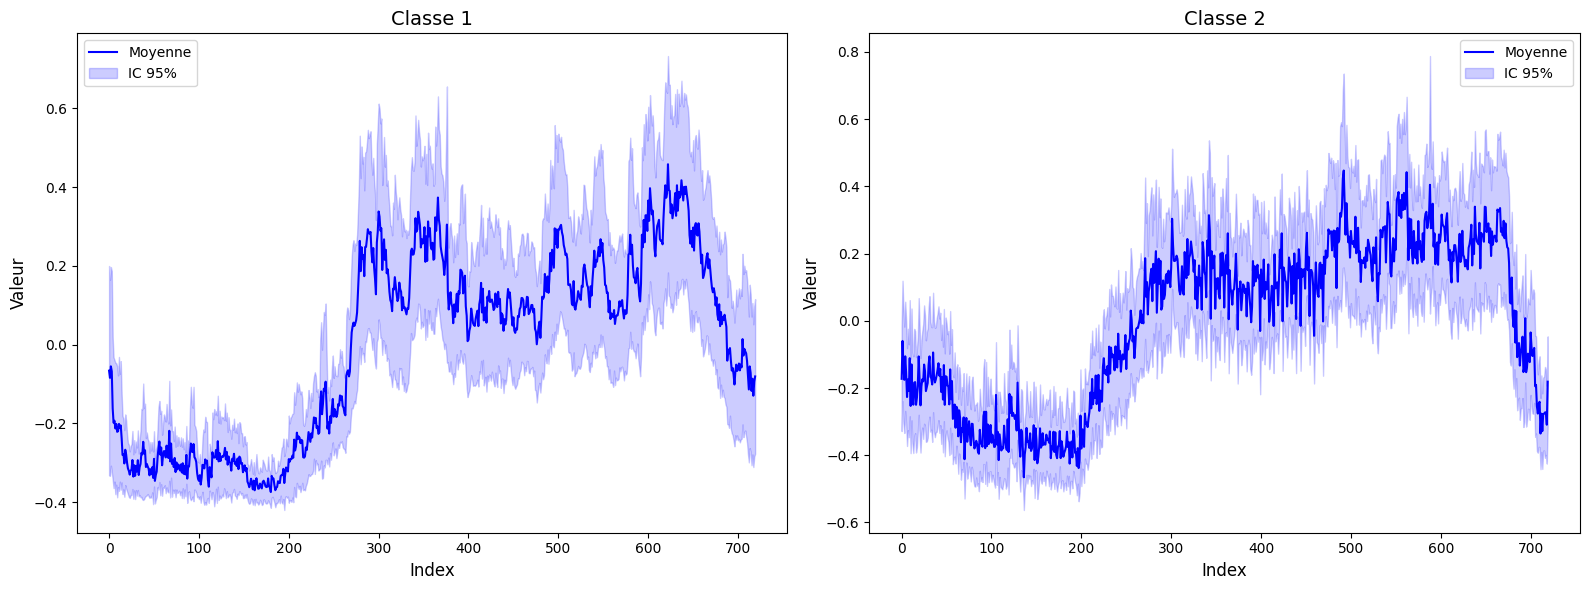

In [6]:
df0 = computers_X_train[computers_X_train["label"]==1].iloc[:, :-1]
df1 = computers_X_train[computers_X_train["label"]==2].iloc[:, :-1]
utils.plot_classes(df0, df1, num_seg=None)

### 3. *Adiac*

In [7]:
utils.describe_ecg_dataset(adiac_x_train, adic_y_train, adiac_x_test, adiac_y_test)

Nombre d'exemples dans l'ensemble d'entraînement : 390
Nombre d'exemples dans l'ensemble de test : 391
Longueur des séries temporelles : 176


Répartition des classes (Ensemble d'entraînement) :
label
1     13
2     10
3      5
4     14
5      4
6     12
7     10
8     13
9      9
10    11
11    10
12    12
13     6
14    11
15    12
16    10
17    11
18     9
19    14
20     9
21     8
22    10
23     9
24    15
25    13
26     9
27    13
28    13
29     9
30    13
31     9
32    13
33    13
34     9
35    10
36    11
37     8
Name: count, dtype: int64

Répartition des classes (Ensemble de test) :
label
1      7
2     13
3     15
4      6
5     16
6      8
7     10
8     12
9     11
10     9
11    10
12    14
13    14
14     9
15     9
16    10
17     9
18    13
19    12
20    12
21    12
22    10
23    11
24     8
25    16
26    11
27     7
28     7
29    11
30     7
31    11
32     7
33     7
34    11
35    10
36    14
37    12
Name: count, dtype: int64


